<a href="https://colab.research.google.com/github/PRESSANDPULL/hanghae99/blob/main/%5B4%EC%A3%BC%EC%B0%A8_%EA%B8%B0%EB%B3%B8%EA%B3%BC%EC%A0%9C%5D_%EB%85%BC%EB%A6%AC%EC%A0%81_%EB%AA%A8%EC%88%9C_%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 라이브러리 설치 및 불러오기

In [8]:
# HuggingFace와 필요한 라이브러리 설치
!pip install transformers datasets evaluate accelerate scikit-learn

# 필요한 패키지 불러오기
import random
import evaluate
import numpy as np
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 데이터 불러오기

In [9]:
# IMDb 데이터셋 로드
imdb = load_dataset("imdb")
imdb  # 데이터셋 구조 확인

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

# 데이터 확인

In [10]:
# Train 데이터 예시 출력
print(imdb['train'][0])

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

# Tokenizer 준비 및 데이터 전처리

In [11]:
# Tokenizer 로드
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# 데이터 전처리 함수 정의
def preprocess_function(data):
    return tokenizer(data["text"], truncation=True)

# 데이터셋 Tokenize
imdb_tokenized = imdb.map(preprocess_function, batched=True)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

# Tokenized 데이터 확인

In [12]:
# Tokenized 데이터 확인
print(imdb_tokenized['train'][0].keys())

dict_keys(['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'])


# Train, Validation, Test 데이터 분리

In [13]:
# Train 데이터를 Validation과 분리
imdb_split = imdb_tokenized['train'].train_test_split(test_size=0.2)
imdb_train, imdb_val = imdb_split['train'], imdb_split['test']
imdb_test = imdb_tokenized['test']

# 각 데이터셋 크기 확인
print(len(imdb_train), len(imdb_val), len(imdb_test))

20000 5000 25000


# 모델 구성

In [14]:
# BERT Config 설정
from transformers import BertConfig

config = BertConfig()
config.hidden_size = 64
config.intermediate_size = 64
config.num_hidden_layers = 2
config.num_attention_heads = 4
config.num_labels = 2

# 모델 생성
model = AutoModelForSequenceClassification.from_config(config)

# 학습 설정

In [15]:
# 학습 인자 설정
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir='hf_transformer',
    num_train_epochs=10,
    per_device_train_batch_size=128,
    per_device_eval_batch_size=128,
    logging_strategy="epoch",
    do_train=True,
    do_eval=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-3,
    load_best_model_at_end=True
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


# 평가 메트릭 구현

In [16]:
# 평가 메트릭 설정
accuracy = evaluate.load("accuracy")

def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

# Trainer 구성

In [17]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=imdb_train,
    eval_dataset=imdb_val,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

<ipython-input-17-a22bcdb59a1c>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


# 학습 실행

In [25]:
from transformers import TrainerCallback

class CustomCallback(TrainerCallback):
    def __init__(self):
        self.train_loss = []
        self.eval_loss = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if "loss" in logs:
            self.train_loss.append(logs["loss"])
        if "eval_loss" in logs:
            self.eval_loss.append(logs["eval_loss"])

# Callback 추가
callback = CustomCallback()
trainer.add_callback(callback)

import os

# wandb 비활성화
os.environ["WANDB_DISABLED"] = "true"

# 학습 실행
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.234100,0.313694,0.877200
2,0.137700,0.358886,0.879000
3,0.084200,0.413442,0.868600
4,0.051000,0.568625,0.861400
5,0.031600,0.536539,0.869600
6,0.021200,0.638302,0.871000
7,0.017600,0.660477,0.872800
8,0.014500,0.682792,0.868000
9,0.014000,0.692450,0.873400
10,0.013600,0.683054,0.874000


TrainOutput(global_step=1570, training_loss=0.061943201198699366, metrics={'train_runtime': 380.9761, 'train_samples_per_second': 524.967, 'train_steps_per_second': 4.121, 'total_flos': 33699840000000.0, 'train_loss': 0.061943201198699366, 'epoch': 10.0})

# 모델 저장

In [26]:
# 모델 저장
trainer.save_model()

# 테스트 데이터로 평가

In [27]:
# 테스트 데이터 평가
trainer.evaluate(imdb_test)

{'eval_loss': 0.3609135150909424,
 'eval_accuracy': 0.85304,
 'eval_runtime': 24.909,
 'eval_samples_per_second': 1003.654,
 'eval_steps_per_second': 7.869,
 'epoch': 10.0}

# 그래프로 그려보기

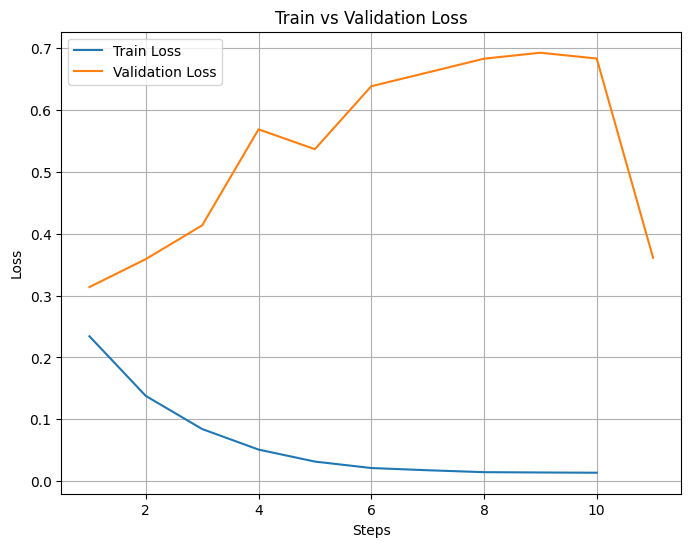

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(callback.train_loss) + 1), callback.train_loss, label="Train Loss")
plt.plot(range(1, len(callback.eval_loss) + 1), callback.eval_loss, label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid()
plt.show()

Training Loss는 줄었으나, Validation Loss가 늘어나는 것으로 보아 Overfitting이 발생했을 수 있다는 ChatGPT의 의견이 있었습니다..